# Early cancer detection using signature framework

On essaie ici de différentier les dynamiques malignes des dynamiques bénignes pour les biomarqueurs.

In [1]:
!pip install gudhi
!pip install signatory
!pip install iisignature
!pip install giotto-tda
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp310-cp310-linux_x86_64.whl size=11869526 sha256=32b89ea97c109a8a9903644442ddec696178ffdf5e685f28c8362ae2ddb81334
  Stored in directory: /root/.cache/pip/wheels/71/b4/17/46d769da4808e9f83f9790a2b805f81f43ececc2c02f5b1e62
Successfully built signatory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=3245484 sha256=fb457aa2763fee49d2e548678b5ad3e5cd628900a53e8db8f6a900dec9fb513f
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.

In [2]:
import signatory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gudhi
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.dtm_rips_complex import DTMRipsComplex
from gudhi.cover_complex import MapperComplex, GraphInducedComplex, NerveComplex
import networkx as nx
from gtda.mapper import *
from sklearn.cluster import DBSCAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
local = False
if local:
  import sys
    # Add the directory containing TDA_utils.py to the Python path
  sys.path.append('G://Mon Drive/Etude_Cancer/TDA')
else:
  %cd /content/drive/MyDrive/Etude_Cancer/TDA

from TDA_utils import corr_metric, compute_complex



/content/drive/MyDrive/Etude_Cancer/TDA


On importe les données bénignes:

In [ ]:
if local:
  path = 'G://Mon Drive/Etude_Cancer/TDA/Simul/benign_dwi_b'
else:
  path = "./Simul/benign_dwi_b"


data = {}
for b in [0.1,0.12,0.14,0.17]:
  df = pd.read_csv(path+str(b)+".csv",sep = ";")
  df_numpy = df.to_numpy().T[:,:,None]
  data[str(b)]= torch.tensor(pd.read_csv(path+str(b)+".csv",sep = ";").to_numpy().T[1:,:,None])

torch.Size([4000, 7, 1])


<ipython-input-5-735dfcf2df9b>:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  data_ben= (data_ben.T-data_ben.mean(axis=1)[:,0]).T


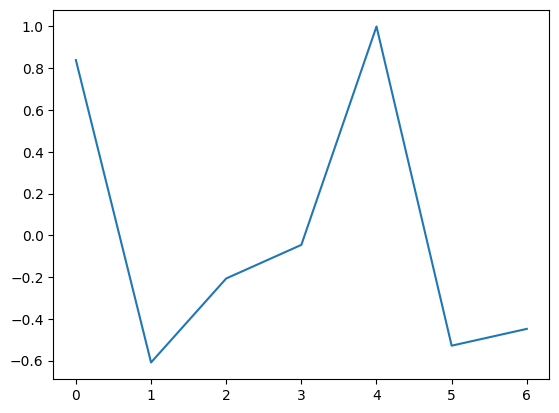

In [ ]:
scale = True
Time = False

data_ben = torch.cat((data['0.1'][:,1:],data['0.12'][:,1:],data['0.14'][:,1:],data['0.17'][:,1:]))
data_ben= (data_ben.T-data_ben.mean(axis=1)[:,0]).T
if scale:
  data_ben = data_ben/np.abs(data_ben[:,:,0]).max(dim = 1)[0][:,None,None]

time = torch.tensor([300*i for i in range(7)])[None,:,None]
times = time.repeat(data_ben.shape[0],1,1)
if Time:
  data_ben= torch.cat((times,data_ben),axis = -1)

print(data_ben.shape)
plt.plot(data_ben[0,:])

In [ ]:
import os
import re


def starts_with_benign(s):
    return s.startswith("benign")
def starts_with_des(s):
    return s.startswith("desk")
classif = []
data_ben_mal = {}
if local:
  directory = 'G://Mon Drive/Etude_Cancer/TDA/Simul/'
else:
  directory = "./Simul/"

for filename in os.listdir(directory):
    if starts_with_benign(filename) or starts_with_des(filename):
      i = 1
    else:
      f = os.path.join(directory, filename)
      data_ben_mal[filename]= torch.tensor(pd.read_csv(f,sep = ";").to_numpy().T[1:,:,None])



In [ ]:
data_mal = torch.cat(tuple([data_ben_mal[filename] for filename in data_ben_mal.keys()]))
data_mal[:,:,0] = (data_mal[:,:,0].T-data_mal[:,:,0].mean(axis=1)).T
if scale:
  data_mal = data_mal/np.abs(data_mal[:,:,0]).max(dim = 1)[0][:,None,None]

time = torch.tensor([300*i for i in range(7)])[None,:,None]
times = time.repeat(data_mal.shape[0],1,1)
if Time:
  data_mal = torch.cat((times,data_mal),axis = -1)

#plt.plot(data_mal[0,:,1].T)

In [ ]:
rang = 50

idx = [i for i in range(rang)]
n_samples = 20
for k in range(1,n_samples):
  idx += [i+k*1000 for i in range(rang)]
idx = np.array(idx)

classe = [0 for i in range(4*rang)]

for k in range(n_samples-4):
  classe += [k-3 for i in range(rang)]

classe = np.array(classe)

data_all = torch.cat((data_ben,data_mal))[idx,:]



In [ ]:
len(classe)

1000

In [ ]:
TD = TimeDelayEmbedding(dim=2,delay=1,skip = 1)
test = torch.tensor(TD.transform(data_all))
test.shape

<ipython-input-10-3fbe02b24278>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  test = torch.tensor(TD.transform(data_all))


torch.Size([1000, 6, 2])

In [ ]:
pers = []
pers0 = []
pers1 = []
pers2 = []
pers3 = []
dim = 3
for i in range(test.shape[0]):
  #comp = gudhi.RipsComplex(points = test[i],max_edge_length = 10).create_simplex_tree(max_dimension = dim)
  comp = gudhi.AlphaComplex(points = test[i]).create_simplex_tree()
  #comp = DTMRipsComplex(points = test[i]).create_simplex_tree(max_dimension = dim)
  pers.append(comp.persistence())
  pers0.append(comp.persistence_intervals_in_dimension(0))
  pers1.append(comp.persistence_intervals_in_dimension(1))
  pers2.append(comp.persistence_intervals_in_dimension(2))
  if dim>3:
    pers3.append(comp.persistence_intervals_in_dimension(3))

In [ ]:
from gudhi.representations import BettiCurve
from gudhi.representations import Landscape

BC = BettiCurve(sample_range = [0,1.5],resolution = 150)

xseq = np.repeat(np.linspace(0,1.5,150)[None],len(pers),axis = 0)

bc0_all = np.array(BC.fit_transform(pers0))
bc1_all = np.array(BC.fit_transform(pers1))
bc2_all = np.array(BC.fit_transform(pers2))

In [ ]:
depth = 2
paths = torch.cat((torch.tensor(xseq)[:,:,None],torch.tensor(bc0_all[:,:,None])),dim=-1)
logsignatures = signatory.logsignature(paths, depth = depth)
signatures = signatory.signature(paths, depth = depth)
signatures.shape

torch.Size([1000, 6])

In [ ]:
from group_mean import mean as smean

M = smean(signatures[:4000].numpy(),channels = 2, depth = depth)

height = lambda S : np.linalg.norm(S)
height2 = lambda S : np.linalg.norm(S-M)
def LevyArea(s):
  return(0.5*(s[3]-s[4]))
def LogLevyArea(ls):
  return ls[2]


n_interval = 50
pipe = make_mapper_pipeline(filter_func = None, cover = CubicalCover(n_intervals=n_interval, overlap_frac=0.3),clusterer = DBSCAN(eps = 0.1),n_jobs = 1)

In [ ]:
graph = pipe.fit_transform(signatures)
for i in range(len(graph.vs["node_elements"])):
      print(f"""
      Node id : {i}
      Size cluster : {len(graph.vs["node_elements"][i])}
      With element : {graph.vs["node_elements"][i]}
      """)


      Node id : 0
      Size cluster : 17
      With element : [  0   7  15  20  24  28  65  76  82  84  86  98 109 116 137 150 187]
      

      Node id : 1
      Size cluster : 31
      With element : [  0   7  20  23  24  45  48  52  53  75  80  83  97 101 108 115 116 118
 120 123 125 127 141 147 158 178 181 191 194 196 199]
      

      Node id : 2
      Size cluster : 18
      With element : [  0  15  24  28  65  76  82  84  86  98 109 113 116 122 137 150 177 187]
      

      Node id : 3
      Size cluster : 3
      With element : [  0  24 116]
      

      Node id : 4
      Size cluster : 189
      With element : [  1  10  12  13  19  27  60  95  99 128 136 159 160 168 252 266 285 295
 330 360 364 373 381 385 398 402 413 462 500 501 502 503 504 505 506 507
 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525
 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543
 544 545 546 547 548 549 554 559 598 600 601 602 603 604 605 606 607 608
 6

In [ ]:
plotly_params = {"node_trace": {"marker_colorscale":"Blues"}}
fig = plot_static_mapper_graph(pipe,signatures,color_data=classe,plotly_params = plotly_params)
fig.update_layout(
    title=dict(text=r"$\textbf{Nerve complex on signature of betti curves with lens: } LevyArea(X)$")
)
fig.show()

torch.Size([1000, 3])

In [ ]:
pers = []
pers0 = []
pers1 = []
pers2 = []
pers3 = []
dim = 2
for i in range(logsignatures.shape[0]):
  comp = gudhi.RipsComplex(points = logsignatures,max_edge_length = 100).create_simplex_tree(max_dimension = dim)
  #comp = gudhi.AlphaComplex(points = test[i]).create_simplex_tree()
  #comp = DTMRipsComplex(points = test[i]).create_simplex_tree(max_dimension = dim)
  pers.append(comp.persistence())
  pers0.append(comp.persistence_intervals_in_dimension(0))
  pers1.append(comp.persistence_intervals_in_dimension(1))
  pers2.append(comp.persistence_intervals_in_dimension(2))
  if dim>3:
    pers3.append(comp.persistence_intervals_in_dimension(3))